In [87]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

In [89]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../../data/regional_datasets/univariate/wsc_data_univ.csv')
# ignore values before march 
enc = enc[enc.date >= "2020-03-01"]
esc = esc[esc.date >= "2020-03-01"]
mid_atlantic = mid_atlantic[mid_atlantic.date >= "2020-03-01"]
mountain = mountain[mountain.date >= "2020-03-01"]
new_england = new_england[new_england.date >= "2020-03-01"]
pacific = pacific[pacific.date >= "2020-03-01"]
south_atlantic = south_atlantic[south_atlantic.date >= "2020-03-01"]
wnc = wnc[wnc.date >= "2020-03-01"]
wsc = wsc[wsc.date >= "2020-03-01"]
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    df.drop(columns=["Unnamed: 0", "date"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    print
    


## Sarimax

In [18]:
# def build_sarima_model(df, params=None, seasonal_params=None, plot=False):
#     region = df["region"].iloc[0]
#     print(f"Training model for {region}...")

#     size = round(df.shape[0]*0.15)
#     train = df.iloc[:-size]['new_confirmed']
#     test = df.iloc[-size:]['new_confirmed']

#     if params and seasonal_params:
#          model = SARIMAX(train, order=params, seasonal_order=seasonal_params)
#     elif params:
#         model = SARIMAX(train, order=params, seasonal_order=(1, 1, 1,7))
#     else:
#         model = SARIMAX(train, order=(2, 0, 3), seasonal_order=(1, 1, 1,7))
#     model_fit = model.fit(disp=False)

#     pred = model_fit.forecast(steps=size)    

#     # calculate metrics
#     mae = mean_absolute_error(test, pred)
#     mse = mean_squared_error(test, pred)
#     rmse = mean_squared_error(test, pred, squared=False)
#     mase = mean_absolute_scaled_error(test, pred, y_train=train)
#     print(f'MAE: {round(mae, 2)}')
#     print(f'MSE: {round(mse, 2)}')
#     print(f'RMSE: {round(rmse, 2)}')
#     print(f'MASE: {round(mase, 2)}')

#     # plot predictions
#     if plot:
#         plt.figure(figsize=(15, 5))
#         plt.title(f'SARIMA Predictions for {region}')
#         plt.plot(test.index, test, label='True')
#         plt.plot(pred.index, pred, label='Predicted')
#         plt.legend() 
#         plt.show()



In [101]:
def build_baseline_model(df, params=None, seasonal_params=None, plot=False, test_perf = False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])


    if not params:
        params = (1, 1, 1)
    if not seasonal_params:
        seasonal_params = (1, 1, 1, 7)
    
    # model = SARIMAX(train, order=params, seasonal_order=seasonal_params)
    # model_fit = model.fit(disp=False)

    # val_pred = model_fit.forecast(steps=len(val))    

    # # calculate metrics
    # mae = round(mean_absolute_error(val, val_pred), 2)
    # rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
    # mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
    # aic = round(model_fit.aic, 2)

    # print(f"Validatation Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")

    # # plot predictions
    # if plot and not test_perf:
    #     plt.figure(figsize=(15, 5))
    #     plt.title(f'Validation SARIMA Predictions for {region}')
    #     plt.plot(val.index, val, label='True Val')
    #     plt.plot(val_pred.index, val_pred, label='Predicted')
    #     plt.legend() 
    #     plt.show()

    
    model = SARIMAX(train_val, order=params, seasonal_order=seasonal_params)
    model_fit = model.fit(disp=False)

    test_pred = model_fit.forecast(steps=len(test))
    test_pred[test_pred < 0] = 0

    mae = round(mean_absolute_error(test, test_pred), 2)
    rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
    aic = round(model_fit.aic, 2)

    print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
    
    # plot both validation and test
    # if plot:
    plt.figure(figsize=(15, 5))
    plt.title(f'ARIMA Predictions for {region}')
    # plt.plot(val.index, val, label='True Val', color="#1f77b4")
    # plt.plot(val_pred.index, val_pred, label='Val Predicted', color="purple")
    plt.plot(test.index, test, label='True Test', color="#1f77b4")
    plt.plot(test_pred.index, test_pred, label='Test Predicted', color="#ff7f0e")
    plt.legend() 
    plt.show()



In [102]:
# params = {
#     "East North Central": (7, 0, 5),
#     "East South Central": (8, 1, 8),
#     "Mid-Atlantic": (6, 0, 8),
#     "Mountain": (7, 1, 7),  
#     "New England": (8, 0, 5),
#     "Pacific": (8, 1, 6),
#     "South Atlantic": (8, 0, 5),
#     "West North Central": (5, 1, 6),
#     "West South Central": (8, 1, 8),
# }

Training model for East North Central...
Test Stats= AIC: 17587.25, MASE: 0.76, RMSE: 10124.64, MAE: 6456.8


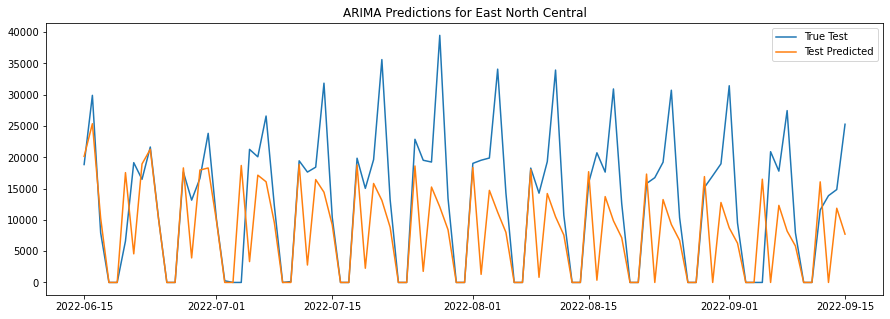


Training model for East South Central...
Test Stats= AIC: 16691.52, MASE: 1.07, RMSE: 5556.85, MAE: 3680.81


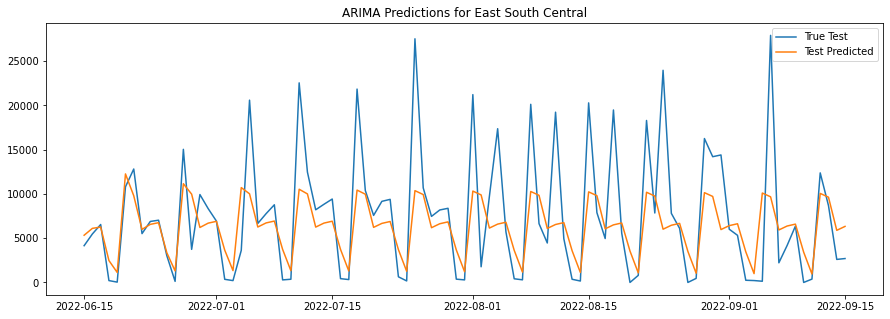


Training model for Mid-Atlantic...
Test Stats= AIC: 16490.71, MASE: 2.48, RMSE: 7143.55, MAE: 6160.21


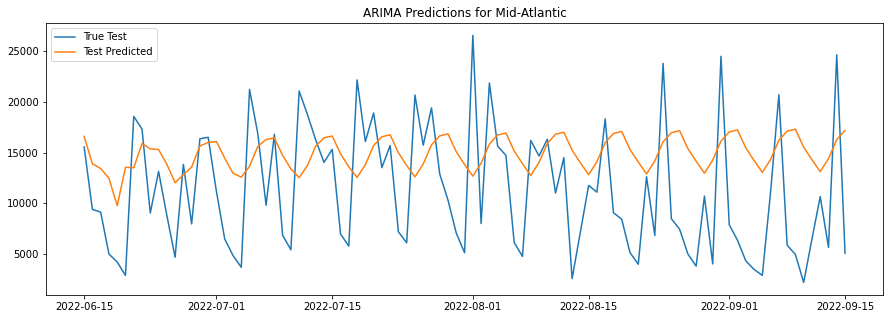


Training model for Mountain...
Test Stats= AIC: 16779.72, MASE: 1.64, RMSE: 6724.47, MAE: 5473.56


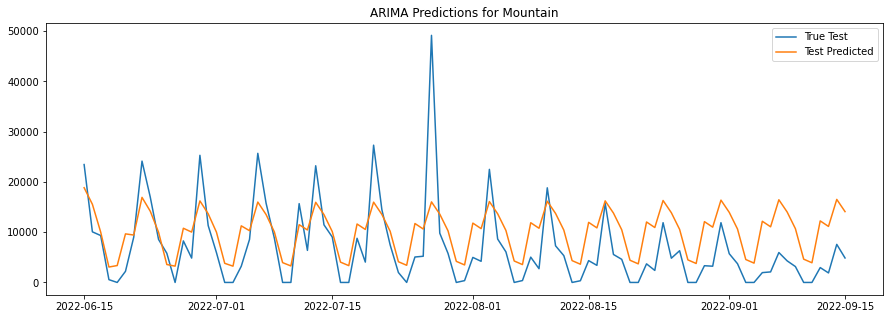


Training model for New England...
Test Stats= AIC: 16478.56, MASE: 0.82, RMSE: 3908.72, MAE: 2265.79


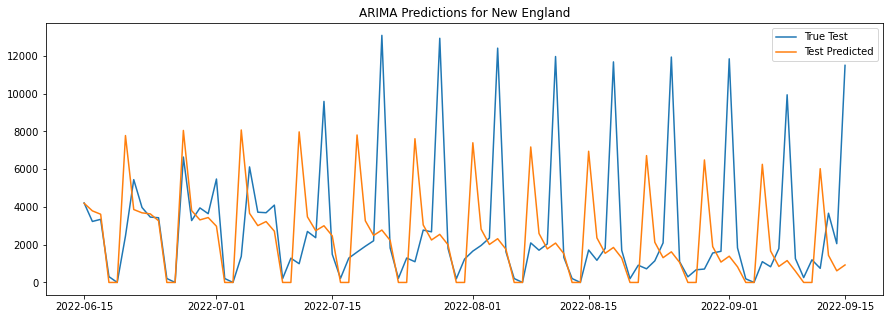


Training model for Pacific...
Test Stats= AIC: 17970.61, MASE: 2.11, RMSE: 21605.09, MAE: 16668.28


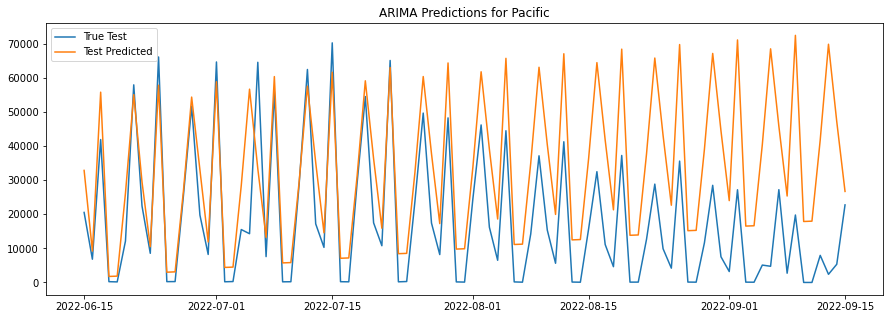


Training model for South Atlantic...
Test Stats= AIC: 18761.47, MASE: 0.7, RMSE: 10138.67, MAE: 7800.69


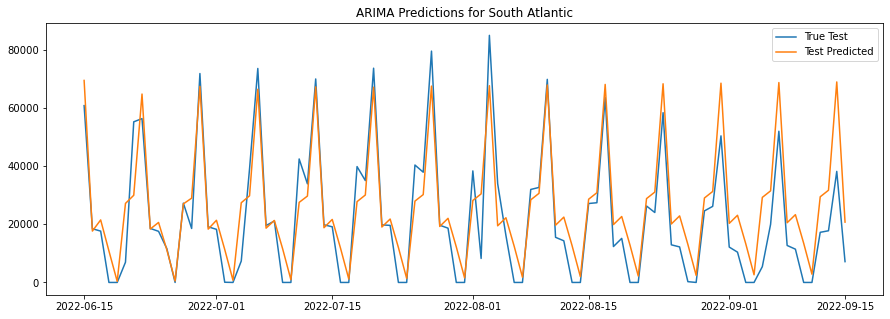


Training model for West North Central...
Test Stats= AIC: 16481.83, MASE: 0.82, RMSE: 3971.14, MAE: 2695.71


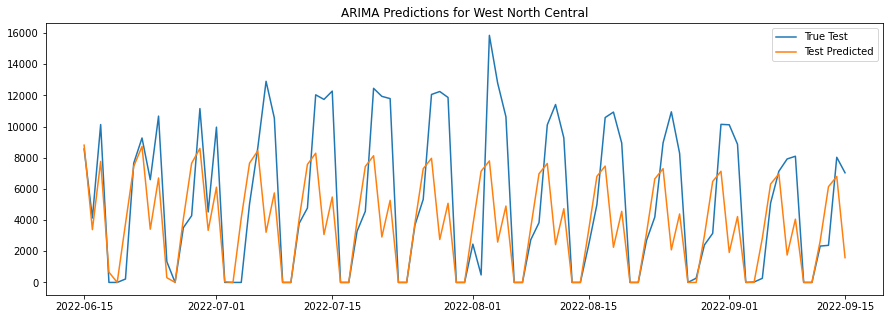


Training model for West South Central...
Test Stats= AIC: 17421.1, MASE: 1.34, RMSE: 8024.92, MAE: 6016.04


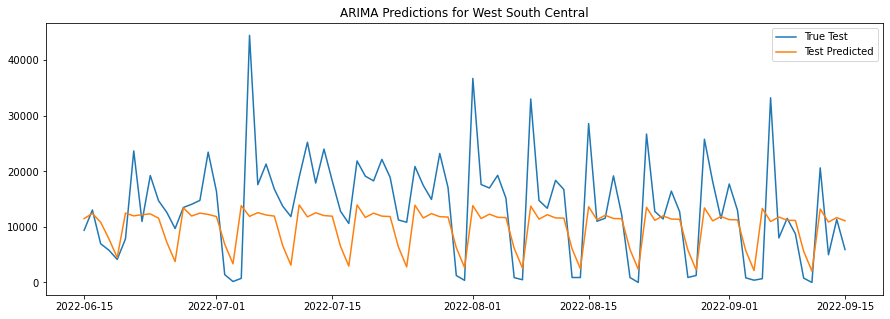


--- 50.89 seconds ---


In [103]:
start_time = time.time()
for df in datasets:
    build_baseline_model(df, plot=True, test_perf=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

# Parameter Optimization on Validation

In [104]:
def parameter_tune(df):
    region = df["region"].iloc[0]
    print(f"Optimizing model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])
    # validation step
    


    results = []
    for p in range(2):
        for q in range(2):
            for P in range(3):
                for Q in range(3):
                    try:
                        model = SARIMAX(train, order=(p, 1, q), seasonal_order=(P, 1, Q, 7))
                        model_fit = model.fit(disp=False)

                        # pred = model_fit.forecast(steps=size)

                        val_pred = model_fit.forecast(steps=len(val))
            
                        mae = round(mean_absolute_error(val, val_pred), 2)
                        rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
                        mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
                        aic = round(model_fit.aic, 2)

                        results.append([p, q, P, Q, aic, mae, rmse, mase])
                    except:
                        continue
                
    results = pd.DataFrame(results, columns=["p", "q", "P", "Q", "aic", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

In [105]:
start_time = time.time()
for df in datasets:
    parameter_tune(df)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Optimizing model for East North Central...
    p  q  P  Q       aic      mae      rmse  mase
0   0  0  0  0  16129.61  6362.53  10871.79  0.74
3   0  0  1  0  16076.67  6483.18  10955.21  0.76
18  1  0  0  0  15998.64  6871.54  11386.05  0.80
21  1  0  1  0  15946.16  7001.33  11462.35  0.82
1   0  0  0  1  16070.83  8133.89  12458.83  0.95

Optimizing model for East South Central...
    p  q  P  Q       aic      mae     rmse  mase
0   0  0  0  0  15686.84  1593.76  2632.20  0.45
3   0  0  1  0  15611.64  1872.05  2842.90  0.52
6   0  0  2  0  15508.95  2059.76  2925.58  0.58
18  1  0  0  0  15319.37  2227.55  3398.98  0.62
21  1  0  1  0  15225.92  3555.86  4939.82  0.99

Optimizing model for Mid-Atlantic...
   p  q  P  Q       aic       mae      rmse  mase
2  0  0  0  2  14778.58   7054.56   9840.23  3.15
4  0  0  1  1  14787.45   7093.74   9873.77  3.17
6  0  0  2  0  14843.91   9737.26  12439.94  4.35
0  0  0  0  0  15149.56  11542.87  14223.73  5.16
3  0  0  1  0  15055.50  11584.

In [113]:
def parameter_tune2(df):
    region = df["region"].iloc[0]
    print(f"Optimizing model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])
    # validation step
    


    results = []
    p, q = 1, 1
    # for p in range(2):
    #     for q in range(2):
    for P in range(1, 4):
        for Q in range(1, 4):
            try:
                model = SARIMAX(train, order=(p, 0, q), seasonal_order=(P, 0, Q, 7))
                model_fit = model.fit(disp=False)

                # pred = model_fit.forecast(steps=size)

                val_pred = model_fit.forecast(steps=len(val))
    
                mae = round(mean_absolute_error(val, val_pred), 2)
                rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
                mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
                aic = round(model_fit.aic, 2)

                results.append([p, q, P, Q, aic, mae, rmse, mase])
            except:
                continue
                
    results = pd.DataFrame(results, columns=["p", "q", "P", "Q", "aic", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

In [114]:
for df in [esc, mountain, mid_atlantic, pacific]:
    parameter_tune2(df)
    print("")

Optimizing model for East South Central...
   p  q  P  Q       aic      mae     rmse  mase
6  1  1  3  1  15046.28  1540.09  2981.36  0.43
5  1  1  2  3  15078.18  2169.53  2801.95  0.61
8  1  1  3  3  15079.36  2176.18  2818.52  0.61
2  1  1  1  3  15078.12  2387.60  3077.50  0.67
7  1  1  3  2  15078.05  2471.01  3106.48  0.69

Optimizing model for Mountain...
   p  q  P  Q       aic      mae     rmse  mase
1  1  1  1  2  15164.15  4226.75  6129.99  1.27
5  1  1  2  3  15163.27  4231.77  5711.95  1.28
8  1  1  3  3  15163.53  4249.95  5775.15  1.28
6  1  1  3  1  15161.76  4385.68  5878.07  1.32
2  1  1  1  3  15164.23  4454.83  5845.04  1.34

Optimizing model for Mid-Atlantic...
   p  q  P  Q       aic      mae     rmse  mase
3  1  1  2  1  14796.14  4289.54  6758.41  1.92
1  1  1  1  2  14778.93  4697.05  7242.81  2.10
7  1  1  3  2  14769.14  5074.97  7654.65  2.27
5  1  1  2  3  14769.67  5565.31  8213.61  2.49
8  1  1  3  3  14767.68  5978.42  8462.49  2.67

Optimizing model for

## Final SARIMA

In [109]:
params = {
    "East North Central": (0, 1, 0),
    "East South Central": (0, 1, 0),
    "Mid-Atlantic": (0, 1, 0),
    "Mountain": (0, 1, 0),
    "New England": (1, 1, 0),
    "Pacific": (1, 1, 0), 
    "South Atlantic": (0, 1, 0),
    "West North Central": (0, 1, 0),
    "West South Central": (0, 1, 1), 
}
# D = 0
seasonal_params = {
    "East North Central": (0, 1, 0, 7),
    "East South Central": (0, 1, 0, 7),
    "Mid-Atlantic": (0, 1, 2, 7),
    "Mountain": (0, 1, 0, 7),
    "New England": (2, 1, 2, 7),
    "Pacific": (2, 1, 1, 7),
    "South Atlantic": (0, 1, 0, 7),
    "West North Central": (0, 1, 0, 7),
    "West South Central": (1, 1, 0, 7)
}

In [115]:
def sarima_final_model(df, params=None, seasonal_params=None):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")
    print(df.shape)
    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False, random_state=42)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])
    print(train_val.shape, test.shape)


    # if not params:
    #     params = (4, 1, 4)
    # if not seasonal_params:
    #     seasonal_params = (1, 1, 1, 7)
    
    model = SARIMAX(train_val, order=params, seasonal_order=seasonal_params)
    model_fit = model.fit(disp=False)

    test_pred = model_fit.forecast(steps=len(val))   
    test_pred[test_pred < 0] = 0 

    # calculate metrics
    mae = round(mean_absolute_error(test, test_pred), 2)
    rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
    aic = round(model_fit.aic, 2)

    print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")

    

    
    # plot both validation and test
    # if plot:
    plt.figure(figsize=(15, 5))
    plt.title(f'SARIMA Predictions for {region}')
    plt.plot(test.index, test, label='True Val')
    plt.plot(test_pred.index, test_pred, label='Test Predicted')
    plt.legend() 
    plt.show()
    plt.savefig(f"sarima_plots/{region}_sarima.png")



Training model for East North Central...
(929, 6)
(836,) (93,)
Test Stats= AIC: 18091.56, MASE: 0.98, RMSE: 11011.23, MAE: 8391.54


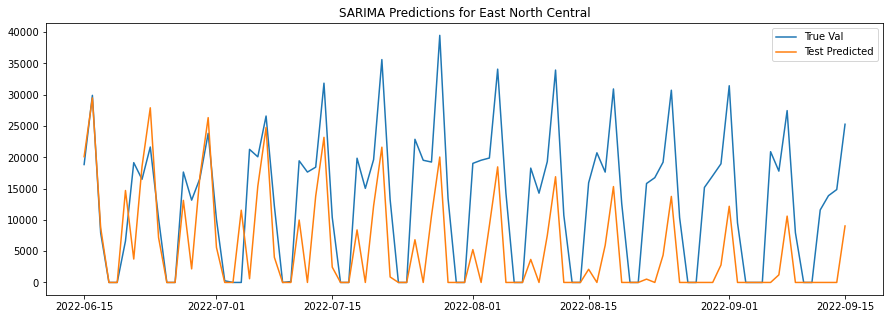


Training model for East South Central...
(929, 7)
(836,) (93,)
Test Stats= AIC: 17586.23, MASE: 4.7, RMSE: 19337.75, MAE: 16105.69


<Figure size 432x288 with 0 Axes>

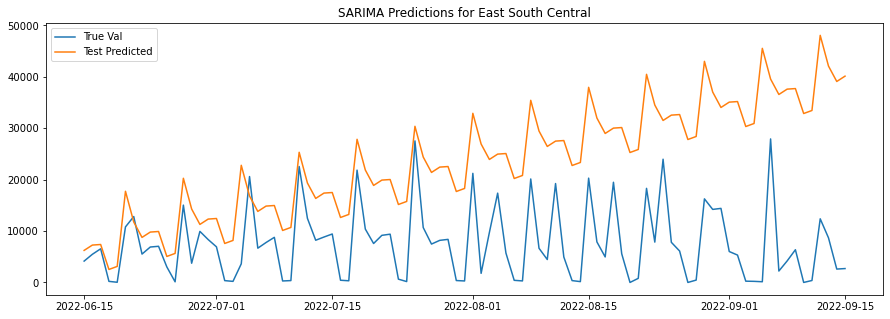


Training model for Mid-Atlantic...
(929, 7)
(836,) (93,)
Test Stats= AIC: 16695.28, MASE: 2.93, RMSE: 8446.37, MAE: 7288.5


<Figure size 432x288 with 0 Axes>

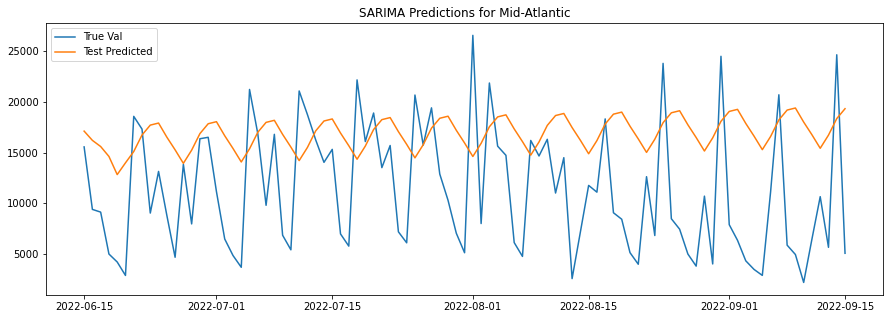


Training model for Mountain...
(929, 6)
(836,) (93,)
Test Stats= AIC: 17678.01, MASE: 6.09, RMSE: 23573.35, MAE: 20378.25


<Figure size 432x288 with 0 Axes>

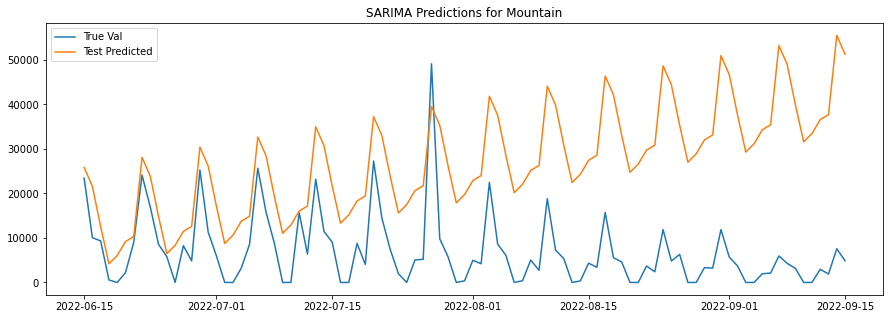


Training model for New England...
(929, 5)
(836,) (93,)
Test Stats= AIC: 16741.77, MASE: 0.94, RMSE: 4261.63, MAE: 2598.49


<Figure size 432x288 with 0 Axes>

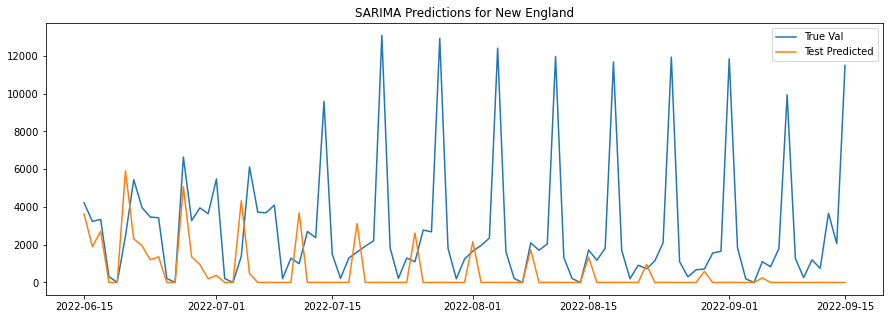


Training model for Pacific...
(929, 7)
(836,) (93,)
Test Stats= AIC: 18181.33, MASE: 4.26, RMSE: 40138.57, MAE: 33650.41


<Figure size 432x288 with 0 Axes>

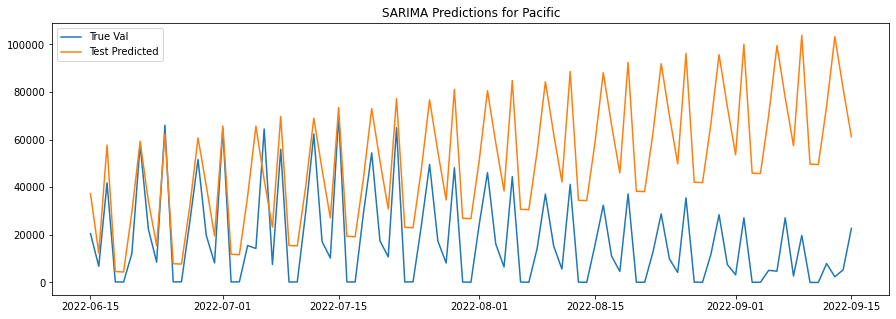


Training model for South Atlantic...
(929, 6)
(836,) (93,)
Test Stats= AIC: 19846.25, MASE: 1.14, RMSE: 16779.9, MAE: 12740.27


<Figure size 432x288 with 0 Axes>

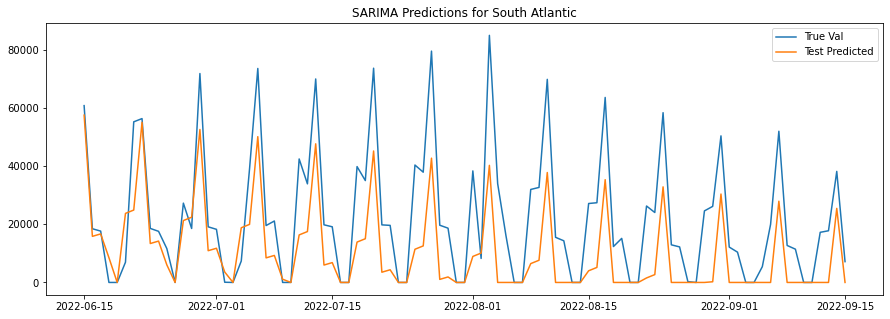


Training model for West North Central...
(929, 6)
(836,) (93,)
Test Stats= AIC: 17023.95, MASE: 1.49, RMSE: 6662.31, MAE: 4882.42


<Figure size 432x288 with 0 Axes>

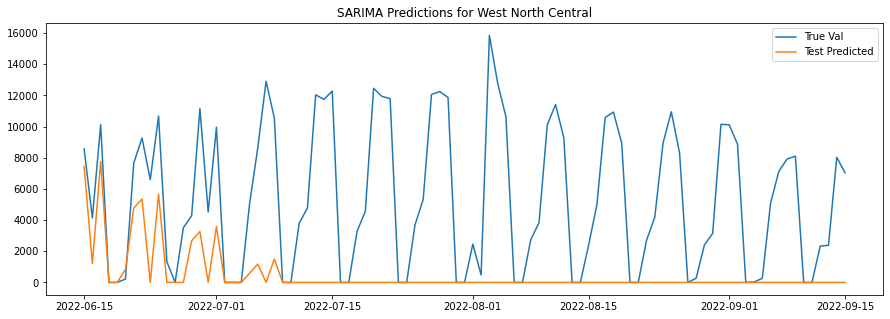


Training model for West South Central...
(929, 5)
(836,) (93,)
Test Stats= AIC: 17559.76, MASE: 1.73, RMSE: 10136.05, MAE: 7756.92


<Figure size 432x288 with 0 Axes>

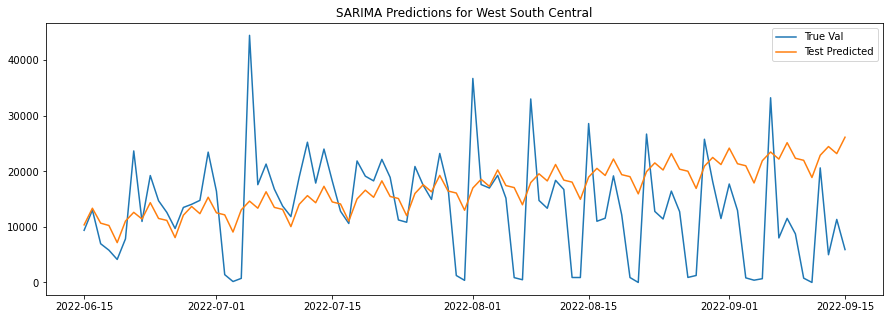


--- 32.02 seconds ---


<Figure size 432x288 with 0 Axes>

In [116]:
start_time = time.time()
for df in datasets:
    region = [df["region"].iloc[0]][0]
    sarima_final_model(df, params=params[region], seasonal_params=seasonal_params[region])
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")